In [27]:
import os
import numpy as np
import scipy
import sys
import matplotlib.pyplot as plt
from __future__ import print_function
# from mpl_toolkits import mplot3d
import cv2
import skimage
import skimage.io
from skimage.filters import gaussian
import numpy.ma as ma

# %matplotlib notebook

In [28]:
def display_vol(im):
    import neuroglancer
    import h5py
    import numpy as np
    import sys

    neuroglancer.set_server_bind_address(bind_port=9991)

    viewer=neuroglancer.Viewer()
    voxel_size=[1, 1, 1]  # resolution

    class SkeletonSource(neuroglancer.skeleton.SkeletonSource):
        def __init__(self):
            super(SkeletonSource, self).__init__()
            self.vertex_attributes['affinity'] = neuroglancer.skeleton.VertexAttributeInfo(
                data_type=np.float32,
                num_components=1,
            )
            self.vertex_attributes['affinity2'] = neuroglancer.skeleton.VertexAttributeInfo(
                data_type=np.float32,
                num_components=1,
            )

        def get_skeleton(self, i):
            pos = np.unravel_index(i, shape, order='C')[::-1]
            vertex_positions = [pos * voxel_size, pos * voxel_size + np.random.randn(3) * 300]
            edges = [0, 1]
            return neuroglancer.skeleton.Skeleton(
                vertex_positions=vertex_positions,
                edges=edges,
                vertex_attributes=dict(affinity=np.random.rand(2), affinity2=np.random.rand(2)))


    with viewer.txn() as s:
        s.voxel_size=voxel_size
        s.layers.append(
           name='im1',
           layer=neuroglancer.LocalVolume(
               data=im,
               voxel_size=voxel_size,
           ))

    print(viewer)

def display_seg(im, seg):
    import neuroglancer
    import h5py
    import numpy as np
    import sys

    neuroglancer.set_server_bind_address(bind_port=9991)

    viewer=neuroglancer.Viewer()
    voxel_size=[1, 1, 1]  # resolution

    with viewer.txn() as s:
        s.voxel_size=voxel_size
        s.layers.append(
           name='im',
           layer=neuroglancer.LocalVolume(
               data=im_resized,
               voxel_size=voxel_size,
           ))
        s.layers.append(
            name='seg',
            layer=neuroglancer.SegmentationLayer(
                source=neuroglancer.LocalVolume(
                    data=seg,
                    voxel_size=voxel_size,
                ),
            ))

    print(viewer)

# Part 1: Processing RFP nucleus stained volume

## Read in file

In [29]:
# file_list = sorted(os.listdir('./data'))
# file_list = [file for file in file_list if file[0]!= '.']
from scipy.io import loadmat
x = loadmat('/Volumes/GoogleDrive/My Drive/MIT Data/C. elegans Data/20180709/one_vol.mat')

In [30]:
vol = x['part_file']
vol = vol/vol.max()

In [31]:
display_vol(vol)
im = vol

http://127.0.0.1:9991/v/fd66b84f3a313cc9cd621e256ccdbb4cc4d7f8c3/


In [32]:
from skimage import io
# im = io.imread('./data/'+file_list[0])
# im = im/im.max()

In [33]:
im = im.squeeze()
print(im.shape)
print(skimage.__version__)

(660, 114, 87)
0.15.dev0


In [34]:
display_vol(im)

http://127.0.0.1:9991/v/6ff57de0ba916c44529fe2e604862b543843c149/


## Gaussian filtering and subsampling

In [35]:
# Low pass filtering
im_f = gaussian(im, sigma=1)

In [36]:
# im_f_copy = im_f

In [37]:
# im_f_copy[im_f < 0.15] = 0

In [38]:
display_vol(im_f)

http://127.0.0.1:9991/v/9521a73f46f77918b17e98b245bbf00dfe06312b/


In [39]:
from skimage.transform import rescale, resize, downscale_local_mean

In [40]:
# im_resized = image_resized = skimage.transform.resize(im_f, (31, im_f.shape[1] / 4, im_f.shape[2] / 4))
im_resized = im_f

In [41]:
im_mip = np.max(im_f, axis=2)

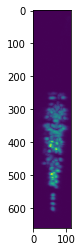

In [43]:

plt.figure()
imgplot = plt.imshow(im_mip)

## Segmentation

### Local maxima and NMS

In [44]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

In [45]:
im1 = im_resized

In [46]:
# threshold for foreground
# get foreground mask
# using yen threshold
thresh = skimage.filters.threshold_otsu(im1, nbins=256)
print(thresh)
binary = im1 >= thresh
# labeled_array, num_features = scipy.ndimage.measurements.label(binary)
# seg = labeled_array.astype(np.uint32)
display_seg(im1, binary.astype(np.uint32))

0.0889959206287
http://127.0.0.1:9991/v/d440f14bb4f7a00700222a57f0cbb1624d7679e5/


In [47]:
newimg = np.zeros_like(im1)
newimg[binary] = im1[binary]
display_vol(newimg.astype(np.double))

http://127.0.0.1:9991/v/53ca64eab0dcb5ee7facccc872e2ab9e4b41a12d/


In [48]:
image_max = ndi.maximum_filter(newimg, size=2, mode='constant')
display_vol(image_max)

http://127.0.0.1:9991/v/45671ba9ab0a4f101ea7633bf660eefb5ff163ff/


In [49]:
coordinates = peak_local_max(image_max, min_distance=3, indices=False)
markers = ndi.label(coordinates)[0] # segmentation

In [120]:
# from skimage.morphology import ball
# from skimage.morphology import binary_dilation
# struct = ball(5)
# mask_d = binary_dilation(markers, struct)

In [121]:
# mask = mask_d.astype(np.double)
# segmentation, _ = scipy.ndimage.label(mask)
# seg = segmentation.astype(np.uint32)

In [50]:
labels = skimage.segmentation.watershed(-newimg, markers, mask=binary, watershed_line=True)

In [51]:
seg2 = np.zeros_like(labels)
seg3 = np.zeros_like(labels)
for i in range(labels.max()):
# for i in range(1):
    seg3.fill(0)
    ind = i+1
    mask1 = labels == ind
    if np.sum(mask1) <= 50:
        continue
    else:
        temp_img = newimg[mask1]
        temp_th = skimage.filters.threshold_otsu(temp_img, 256)+0.01
        mask2 = (newimg * mask1) > temp_th
#         if np.sum(mask2) > 5000:
#             temp_img2 = newimg * mask2
#             seg3[mask2] = 1
#             temp_out = morphological_chan_vese(temp_img2, 10, seg3, smoothing=1, lambda1=1, lambda2=1)
#             seg2[temp_out] = ind
#         else:
        seg2[mask2] = ind
            
seg2 = seg2.astype(np.uint32)

In [52]:
seg2 = np.zeros_like(labels)
seg3 = np.zeros_like(labels)
for i in range(labels.max()):
# for i in range(1):
    seg3.fill(0)
    ind = i+1
    mask1 = labels == ind
    if np.sum(mask1) <= 50:
        continue
    else:
        temp_img = newimg[mask1]
        temp_th = skimage.filters.threshold_otsu(temp_img, 256)+0.01
        mask2 = (newimg * mask1) > temp_th
        if np.sum(mask2) > 5000:
            temp_img2 = newimg * mask2
            seg3[mask2] = 1
            temp_out = morphological_chan_vese(temp_img2, 10, seg3, smoothing=1, lambda1=1, lambda2=1)
            seg2[temp_out] = ind
        else:
            seg2[mask2] = ind
            
seg2 = seg2.astype(np.uint32)

In [53]:
display_seg(im1, seg2)

http://127.0.0.1:9991/v/3ef5281bc966059ba764b5a07449375e76c19844/


In [38]:
# eroded = skimage.morphology.erosion(labels)
# eroded_seg, _ = scipy.ndimage.label(eroded)
# seg1 = eroded_seg.astype(np.uint32)

In [58]:
# active contour
from skimage.segmentation import morphological_chan_vese
seg3 = np.zeros_like(seg2)
im3 = np.copy(im1)
seg3[seg2 == 23] = 1
im3[seg2!=23] = 0
out = morphological_chan_vese(im3, 10, seg3, smoothing=1, lambda1=1, lambda2=1)

In [54]:
print(out.shape)
print(out.max())
print(out.min())
print(out.mean())

(179, 139, 990)
1
0
0.00166128143701


In [59]:
display_seg(im1, out.astype(np.uint32))

http://127.0.0.1:9991/v/2196657a49bab91da5a7abe8544227ed97bd1c67/


## random walk segmentation

In [ ]:
labels_rw = skimage.segmentation.random_walker(im1, markers, beta=25000, mode='cg_mg')

/Users/pdai/scikit-image/skimage/segmentation/random_walker_segmentation.py:475: UserWarning: pyamg (http://pyamg.org/)) is needed to use
                this mode, but is not installed. The 'cg' mode will be used
                instead.
  instead.""")


### Segmentation using sobel+watershed

In [38]:
from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import slic, join_segmentations
from skimage.morphology import watershed
from skimage.color import label2rgb
from skimage import data

In [39]:
im_copy = np.copy(im_resized)
edges = np.zeros_like(im_copy)

In [40]:
edges.shape

(179, 139, 990)

In [43]:
for i in range(179):
    edges[i] = sobel(im_copy[i])

In [44]:
markers = np.zeros_like(im_copy)

In [45]:
foreground, background = 1, 2

In [46]:
markers[im_copy < 0.15] = background
markers[im_copy > 0.35] = foreground

In [48]:
im_copy.max()

0.75349842433693126

In [49]:
ws = skimage.morphology.watershed(edges, markers)

In [51]:
seg1 = skimage.measure.label(ws == foreground)

In [52]:
seg1=seg1.astype(np.uint32)

In [53]:
display_seg(im, seg1)

http://127.0.0.1:9991/v/37e6e2682293b344b6f0cc2f8609467cf9d9199d/


## Segmentation using blob detectors

In [55]:
from skimage import feature

<IPython.core.display.Javascript object>


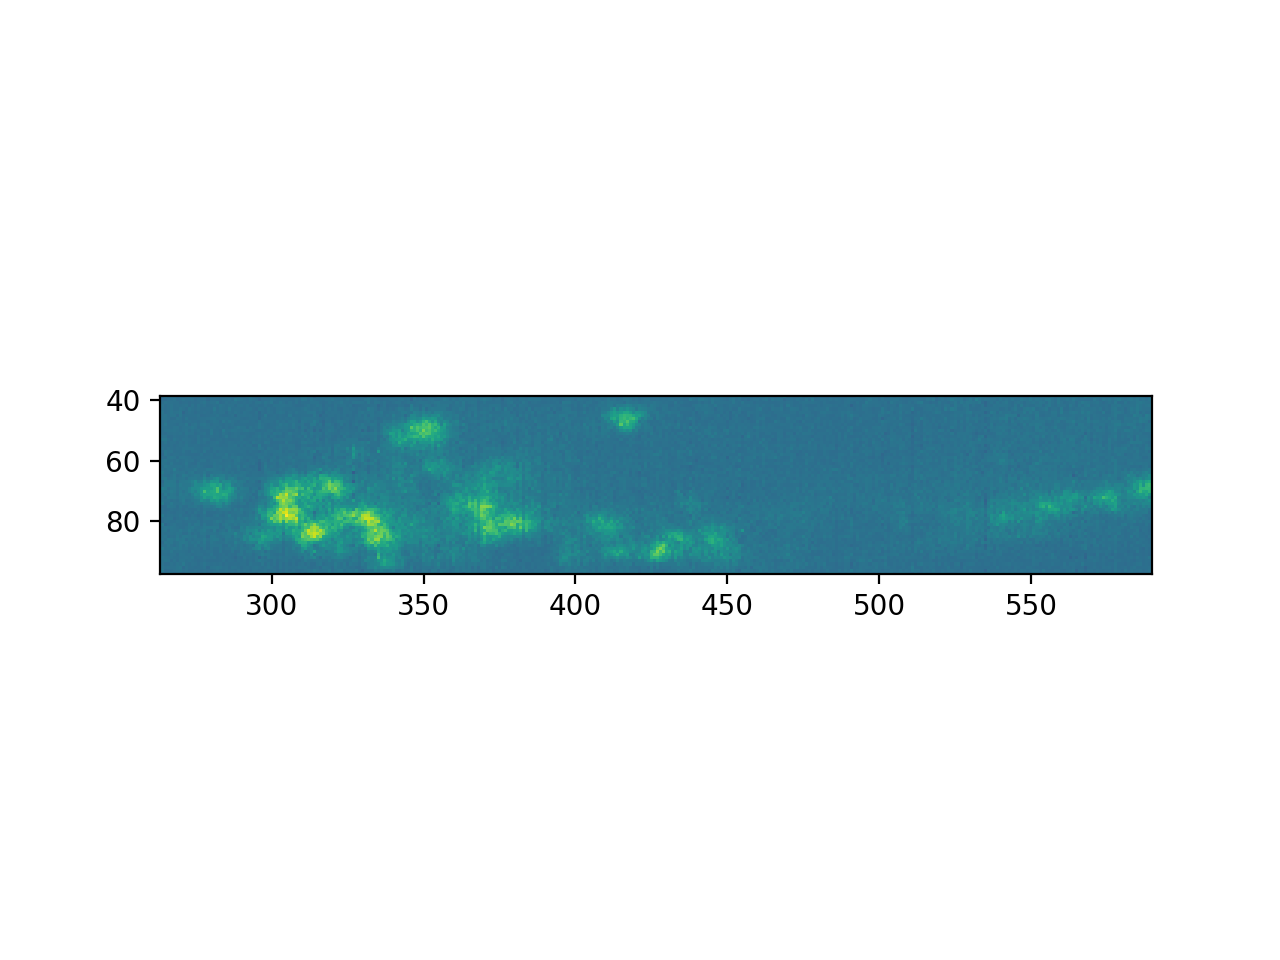

In [59]:
single_im = im[100]
plt.figure()
plt.imshow(single_im)

In [63]:
feature.blob_dog(single_im, min_sigma=1, max_sigma=500, sigma_ratio=1.6, threshold=2.0, overlap=0.5)

array([], shape=(0, 3), dtype=float64)

In [64]:
from skimage import data
from skimage.filters import try_all_threshold

<IPython.core.display.Javascript object>


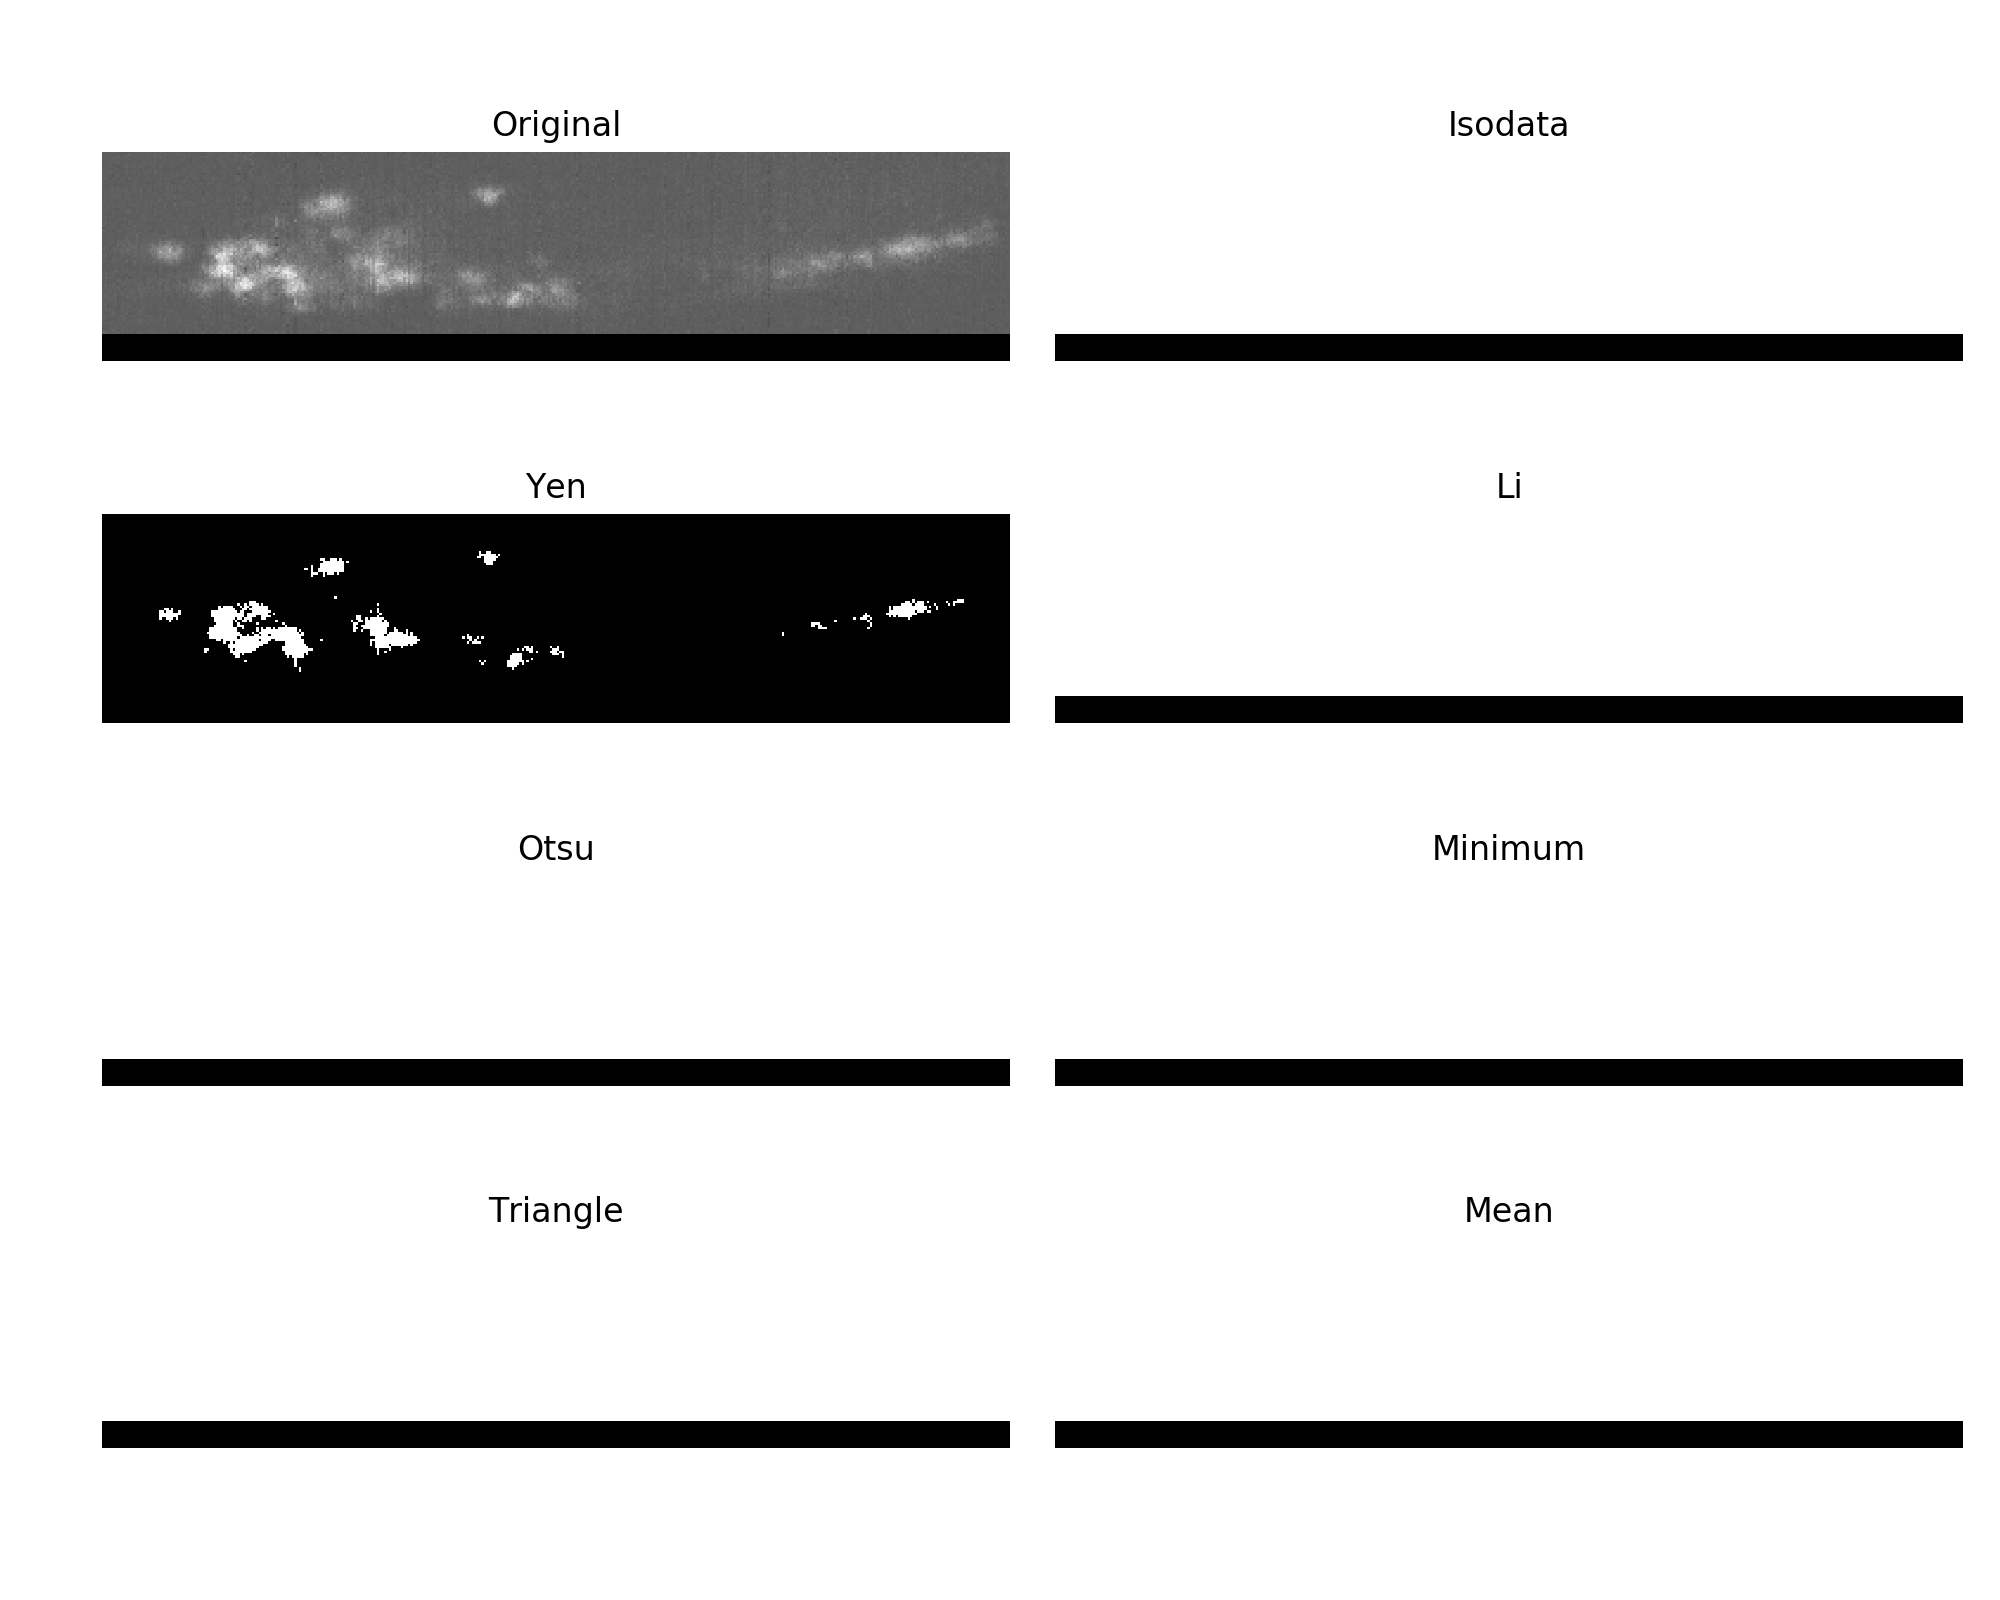

The 'box-forced' keyword argument is deprecated since 2.2.
divide by zero encountered in log


In [67]:
fig, ax = try_all_threshold(single_im, figsize=(10, 8), verbose=False)
plt.show()

In [130]:
# using yen threshold
thresh = skimage.filters.threshold_yen(im_copy, nbins=256)
print(thresh)

0.345844003358


In [138]:
binary = im_copy >= thresh-0.08
labeled_array, num_features = scipy.ndimage.measurements.label(binary)
seg = labeled_array.astype(np.uint32)

In [139]:
display_seg(im_copy, seg)

http://127.0.0.1:9991/v/d7c04b2341fb4fd918144af0fed03a7b5118a871/


In [123]:
# local threshold
mask = skimage.filters.threshold_local(im_copy[100], 7)
labeled_array, num_features = scipy.ndimage.measurements.label(mask)
seg = labeled_array.astype(np.uint32)
overlay = label2rgb(seg, image=im_copy[100])

1

<IPython.core.display.Javascript object>


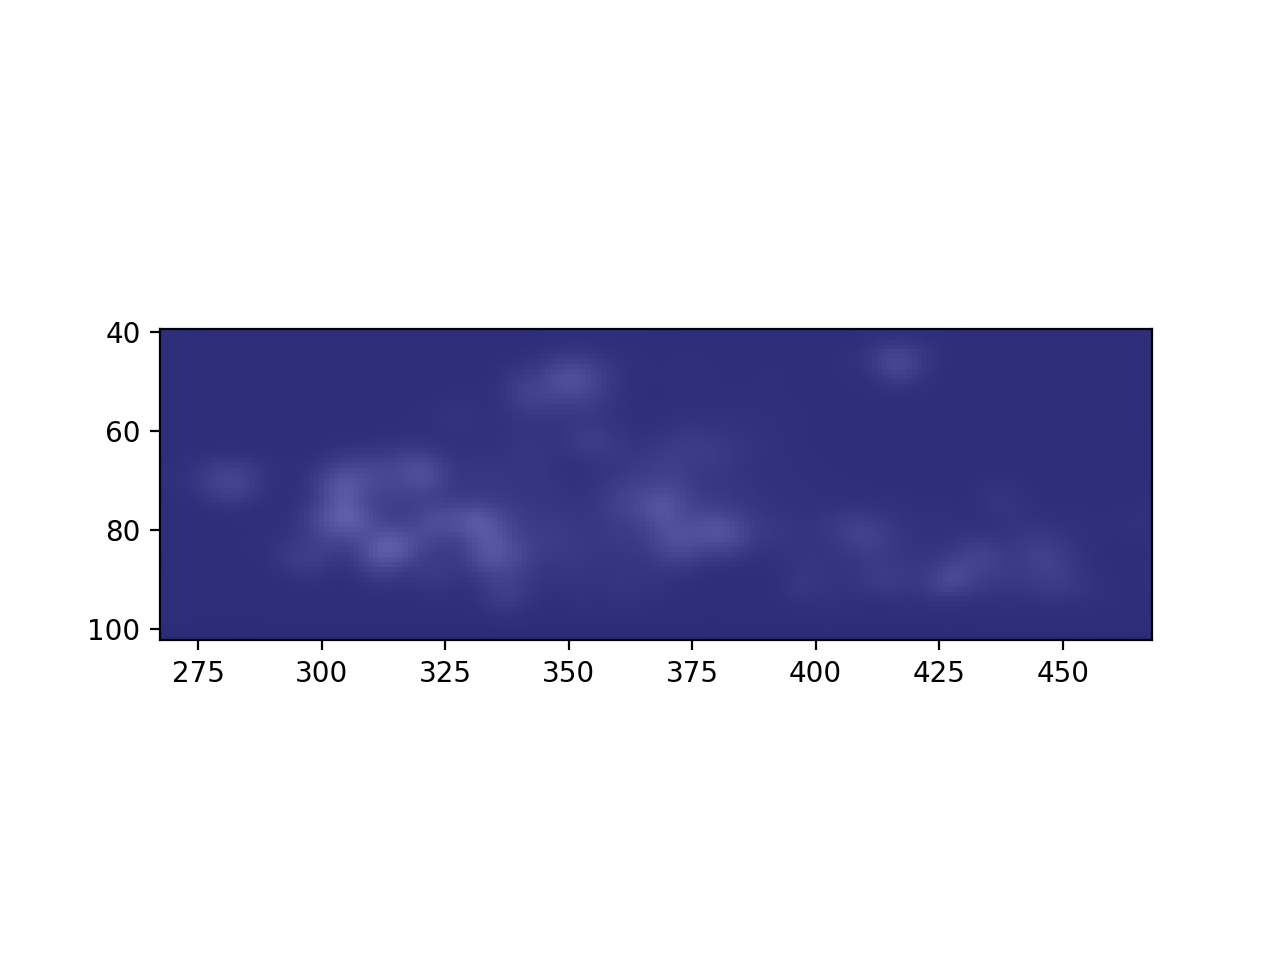

In [124]:
plt.figure()
plt.imshow(overlay)

In [107]:
display_seg(im_copy[100], seg)

http://127.0.0.1:9991/v/5850dbab9c584eaa9b2e709291f7dc519f857995/


### Segmentation using SLIC superpixel

In [222]:
seg2 = slic(im_copy, n_segments=2000, max_iter=10, sigma=1, compactness=0.01,
            multichannel=False)

<IPython.core.display.Javascript object>


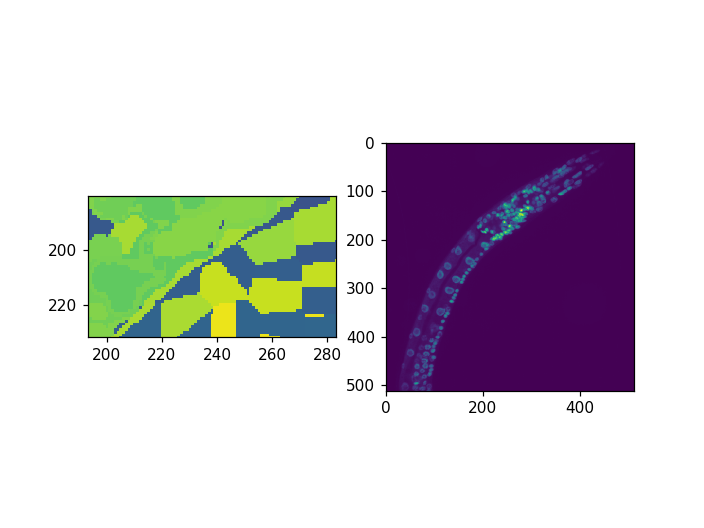

In [223]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(seg2[15])
plt.subplot(1,2,2)
plt.imshow(im_resized[15])

In [155]:
from skimage.feature import peak_local_max
from scipy import ndimage

In [156]:
cd = peak_local_max(im_f, min_distance=5)

In [157]:
mask = np.zeros_like(im_f)

In [158]:
for i in range(len(cd)):
    mask[tuple(cd[i])] = i 

In [159]:
from skimage.morphology import ball
from skimage.morphology import binary_dilation
struct = ball(5)
mask_d = binary_dilation(mask, struct)

In [187]:
mask = mask_d.astype(np.double)
segmentation, _ = ndimage.label(mask)
seg = segmentation.astype(np.double)

<IPython.core.display.Javascript object>


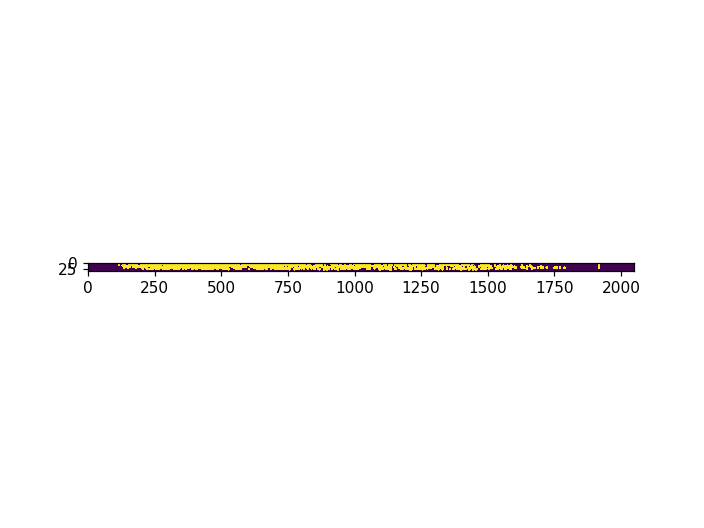

In [160]:
im_mip = np.max(mask_d, axis=1)
plt.figure()
imgplot = plt.imshow(im_mip)

## Display results

In [262]:
import neuroglancer
import h5py
import numpy as np
import sys



neuroglancer.set_server_bind_address(bind_port=9991)

viewer=neuroglancer.Viewer()
voxel_size=[1, 1, 5]  # resolution

class SkeletonSource(neuroglancer.skeleton.SkeletonSource):
    def __init__(self):
        super(SkeletonSource, self).__init__()
        self.vertex_attributes['affinity'] = neuroglancer.skeleton.VertexAttributeInfo(
            data_type=np.float32,
            num_components=1,
        )
        self.vertex_attributes['affinity2'] = neuroglancer.skeleton.VertexAttributeInfo(
            data_type=np.float32,
            num_components=1,
        )

    def get_skeleton(self, i):
        pos = np.unravel_index(i, shape, order='C')[::-1]
        vertex_positions = [pos * voxel_size, pos * voxel_size + np.random.randn(3) * 300]
        edges = [0, 1]
        return neuroglancer.skeleton.Skeleton(
            vertex_positions=vertex_positions,
            edges=edges,
            vertex_attributes=dict(affinity=np.random.rand(2), affinity2=np.random.rand(2)))


with viewer.txn() as s:
    s.voxel_size=voxel_size
    s.layers.append(
       name='im1',
       layer=neuroglancer.LocalVolume(
           data=im_resized,
           voxel_size=voxel_size,
       ))
    s.layers.append(
        name='seg',
        layer=neuroglancer.SegmentationLayer(
            source=neuroglancer.LocalVolume(
                data=seg1,
                voxel_size=voxel_size,
#                 skeletons=SkeletonSource(),
            ),
#             skeleton_shader='void main() { emitRGB(colormapJet(affinity)); }',
#             selected_alpha=0,
#             not_selected_alpha=0,
        ))

print(viewer)

http://127.0.0.1:9991/v/4e94a4323926afeddbfe3451c30155bc1570710a/


In [ ]:
neuroglancer.SegmentationLayer(
        source='precomputed://gs://neuroglancer-public-data/flyem_fib-25/ground_truth',

# Part 2: Segment olumetric GCaMP images